In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pyEDFlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyEDFlib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734985 sha256=8761e38d79936aa73304dfa9584f98de82fd270c27d0201c7b642466d1d8d228
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built pyEDFlib


In [ ]:
import pyedflib
from sklearn.preprocessing import MinMaxScaler


data_root = '/content/drive/MyDrive/CHB-MIT-EEG'

def readData(id, sample):
  loc = f"{data_root}/chb{id}/chb{id}_{sample}.edf"
  f = pyedflib.EdfReader(loc)
  n_signals = f.signals_in_file
  signal_labels = f.getSignalLabels()

  signals = np.zeros((n_signals, f.getNSamples()[0]))
  for i in range(n_signals):
      signals[i, :] = f.readSignal(i)

  f.close()

  return signals

In [ ]:
def min_max_normalize(X):
    X_min, X_max = np.min(X), np.max(X)
    if X_max == X_min:
        return np.zeros_like(X)  # Avoid division by zero

    X = -10 + 20 * (X - X_min) / (X_max - X_min)  # Scale to (-10, 10)
    return X

In [ ]:
from scipy.signal import butter, filtfilt, iirnotch

def denoise_eeg(eeg_signal, fs=256, lowcut=1.0, highcut=40.0, notch_freq=50.0, quality_factor=30.0):
    """
    Denoises an EEG signal using a Butterworth band-pass filter and a notch filter.

    Parameters:
    - eeg_signal: 1D numpy array containing the raw EEG data.
    - fs: Sampling frequency of the EEG signal in Hz (default: 256 Hz).
    - lowcut: Lower cutoff frequency for the band-pass filter (default: 1 Hz).
    - highcut: Upper cutoff frequency for the band-pass filter (default: 40 Hz).
    - notch_freq: Frequency to remove with a notch filter (default: 50 Hz for powerline noise; change to 60 Hz if needed).
    - quality_factor: Quality factor for the notch filter, controlling its bandwidth (default: 30).

    Returns:
    - filtered_signal: The denoised EEG signal as a numpy array.
    """
    # Band-pass filter design (Butterworth)
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b_band, a_band = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b_band, a_band, eeg_signal)

    # Notch filter design to remove powerline interference
    w0 = notch_freq / nyquist
    b_notch, a_notch = iirnotch(w0, quality_factor)
    filtered_signal = filtfilt(b_notch, a_notch, filtered_signal)

    return filtered_signal


In [ ]:
X = min_max_normalize(denoise_eeg(readData("01", "02").reshape(-1)))
y = min_max_normalize(denoise_eeg(readData("01", "03").reshape(-1)))
print(X.shape, y.shape)

(21196800,) (21196800,)


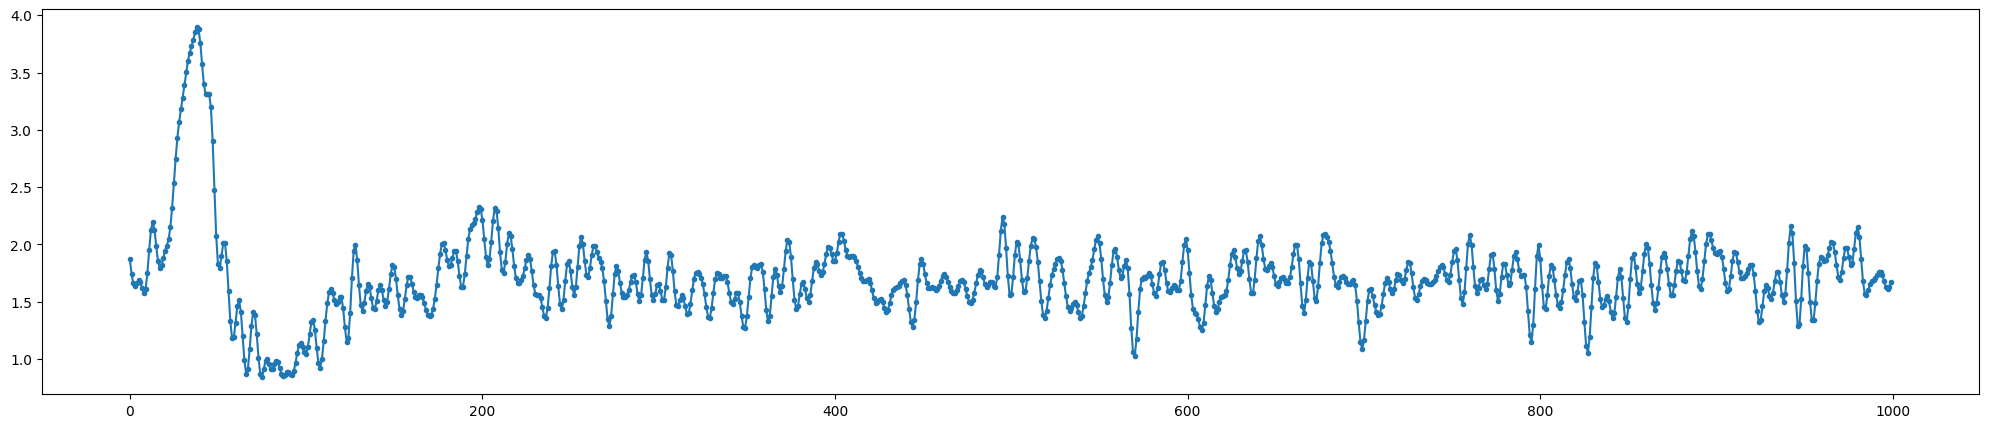

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(X[0:1000])
plt.scatter(y = X[0:1000], x=range(1000), marker='.')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the Encoder class
class Encoder(Model):
    def __init__(self, signal_len=1024, window_size=32, latent_dim=128, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.signal_len = signal_len
        self.window_size = window_size
        self.latent_dim = latent_dim
        self.num_windows = signal_len // window_size

        # Reshape input signal into windows
        self.reshape_windows = layers.Reshape((self.num_windows, self.window_size), name="reshape_to_windows")

        # Project each window to latent_dim using a TimeDistributed Dense layer
        self.window_projection = layers.TimeDistributed(
            layers.Dense(self.latent_dim, activation='relu'),
            name="window_projection"
        )

        # Process the sequence of projected windows with an GRU
        self.rnn = layers.GRU(self.latent_dim, name="encoder_lstm")

    def call(self, inputs):
        # inputs shape: (B, signal_len)
        x = self.reshape_windows(inputs)                     # (B, num_windows, window_size)
        x = self.window_projection(x)                        # (B, num_windows, latent_dim)
        encoded = self.rnn(x)                               # (B, latent_dim)
        return encoded

# Define the Decoder class
class Decoder(Model):
    def __init__(self, signal_len=1024, window_size=32, latent_dim=128, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.signal_len = signal_len
        self.window_size = window_size
        self.latent_dim = latent_dim
        self.num_windows = signal_len // window_size

        # Repeat the latent vector to form a sequence of length num_windows
        self.repeat_vector = layers.RepeatVector(self.num_windows, name="repeat_latent")

        # Process the repeated sequence with an GRU that returns a sequence
        self.rnn = layers.GRU(self.latent_dim, return_sequences=True, name="decoder_lstm")

        # For each time step, project back to a window using TimeDistributed Dense
        self.window_reconstruction = layers.TimeDistributed(
            layers.Dense(self.window_size, activation='linear'),
            name="window_reconstruction"
        )

        # Reshape the reconstructed windows back to the original signal shape
        self.reshape_signal = layers.Reshape((self.signal_len,), name="reshape_to_signal")

    def call(self, inputs):
        # inputs shape: (B, latent_dim)
        x = self.repeat_vector(inputs)                       # (B, num_windows, latent_dim)
        x = self.rnn(x)                                     # (B, num_windows, latent_dim)
        x = self.window_reconstruction(x)                    # (B, num_windows, window_size)
        reconstructed = self.reshape_signal(x)               # (B, signal_len)
        return reconstructed

# Define the AutoEncoder class
class AutoEncoder(Model):
    def __init__(self, signal_len=1024, window_size=32, latent_dim=128, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = Encoder(signal_len, window_size, latent_dim)
        self.decoder = Decoder(signal_len, window_size, latent_dim)

    def call(self, inputs):
        # Encode the input signal
        latent = self.encoder(inputs)
        # Decode the latent representation to reconstruct the signal
        reconstructed = self.decoder(latent)
        return reconstructed

# Example of creating and compiling the autoencoder

# Define parameters
signal_len = 512
window_size = 32
latent_dim = 128

# Instantiate the AutoEncoder
autoencoder = AutoEncoder(signal_len, window_size, latent_dim)

# Compile the model with an optimizer and loss function
autoencoder.compile(optimizer='adam', loss='mse')

# Display model summaries by building the models with a dummy input
sample_input = tf.random.normal((1, signal_len))
_ = autoencoder(sample_input)  # forward pass to build the model

print("Encoder Summary:")
autoencoder.encoder.summary()
print("\nDecoder Summary:")
autoencoder.decoder.summary()
print("\nAutoEncoder Summary:")
autoencoder.summary()


Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_to_windows (Reshape)         │ (1, 16, 32)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ window_projection (TimeDistributed)  │ (1, 16, 128)                │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_lstm (GRU)                   │ (1, 128)                    │          99,072 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,296 (403.50 KB)

 Trainable params: 103,296 (403.50 KB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ repeat_latent (RepeatVector)         │ (1, 16, 128)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_lstm (GRU)                   │ (1, 16, 128)                │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ window_reconstruction                │ (1, 16, 32)                 │           4,128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_to_signal (Reshape)          │ (1, 512)                    │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,200 (403.12 KB)

 Trainable params: 103,200 (403.12 KB)

 Non-trainable params: 0 (0.00 B)


AutoEncoder Summary:


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │         103,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         103,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,496 (806.62 KB)

 Trainable params: 206,496 (806.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train = []

for i in range(0, X.shape[0]-signal_len, 512):
  X_train.append(X[i:i+signal_len])

X_train = np.array(X_train[:])
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(41399, 512, 1)

In [ ]:
X_val = []

for i in range(0, y.shape[0]-signal_len, 512):
  X_val.append(X[i:i+signal_len])

X_val = np.array(X_val[:100])
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_val.shape

(100, 512, 1)

In [ ]:
X_sample = X_train[0:1]
autoencoder.predict(X_sample).shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


(1, 512)

In [ ]:
# Train the model
history = autoencoder.fit(X_train, X_train, epochs=150, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.1545 - val_loss: 0.2129
Epoch 2/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.1019 - val_loss: 0.1953
Epoch 3/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0924 - val_loss: 0.1837
Epoch 4/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0874 - val_loss: 0.1683
Epoch 5/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0813 - val_loss: 0.1550
Epoch 6/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0728 - val_loss: 0.1200
Epoch 7/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0584 - val_loss: 0.0984
Epoch 8/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0513 - val_loss: 0.0865
Epoch 9/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0458 - val_loss: 0.0835
Epoch 10/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0423 - val_loss: 0.0657
Epoch 11/150
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0370 - val_loss: 0.0631
Epoch 12

In [ ]:
i = 0
X_test = X_train[i:i+1]
y_test = autoencoder(X_test)
y_test.shape

TensorShape([1, 512])

In [ ]:
compressed = autoencoder.encoder(X_test)

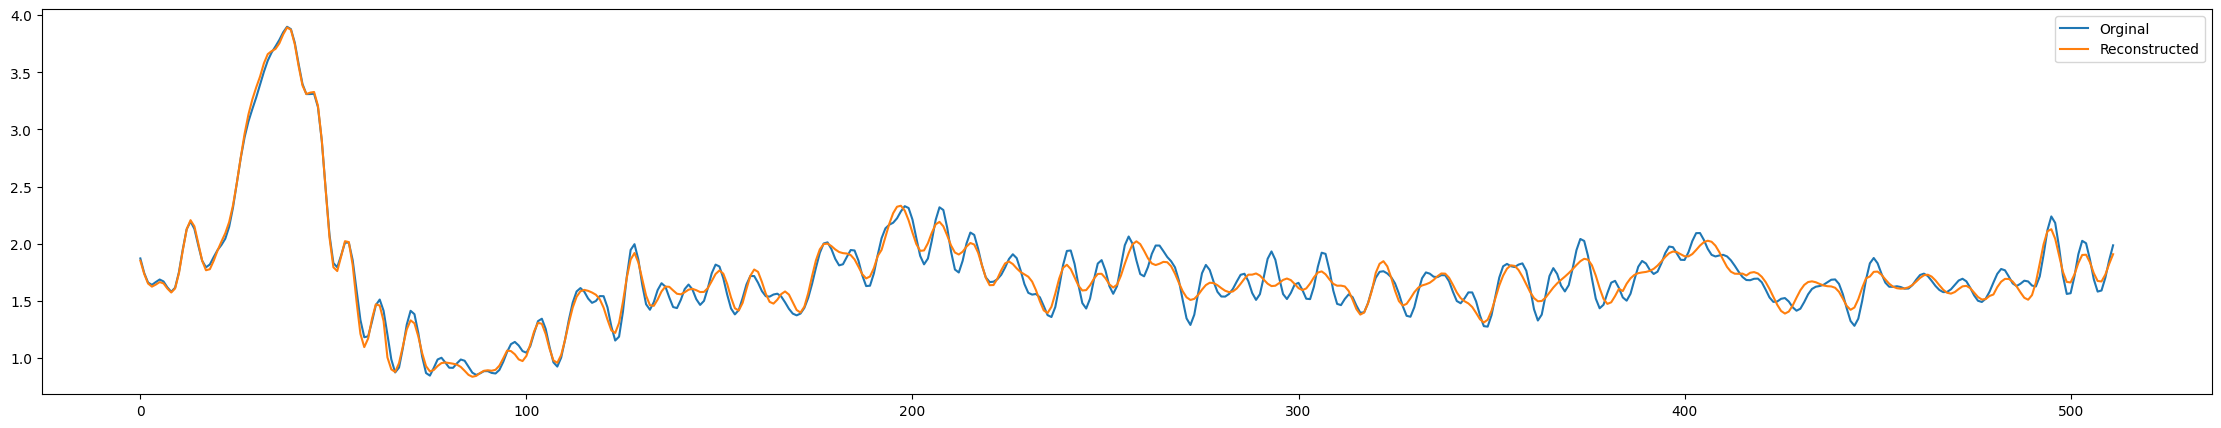

In [ ]:
plt.figure(figsize=(28, 5))
plt.plot(X_test[0], label = 'Orginal')
plt.plot(y_test[0], label = 'Reconstructed')
plt.legend()
plt.show()

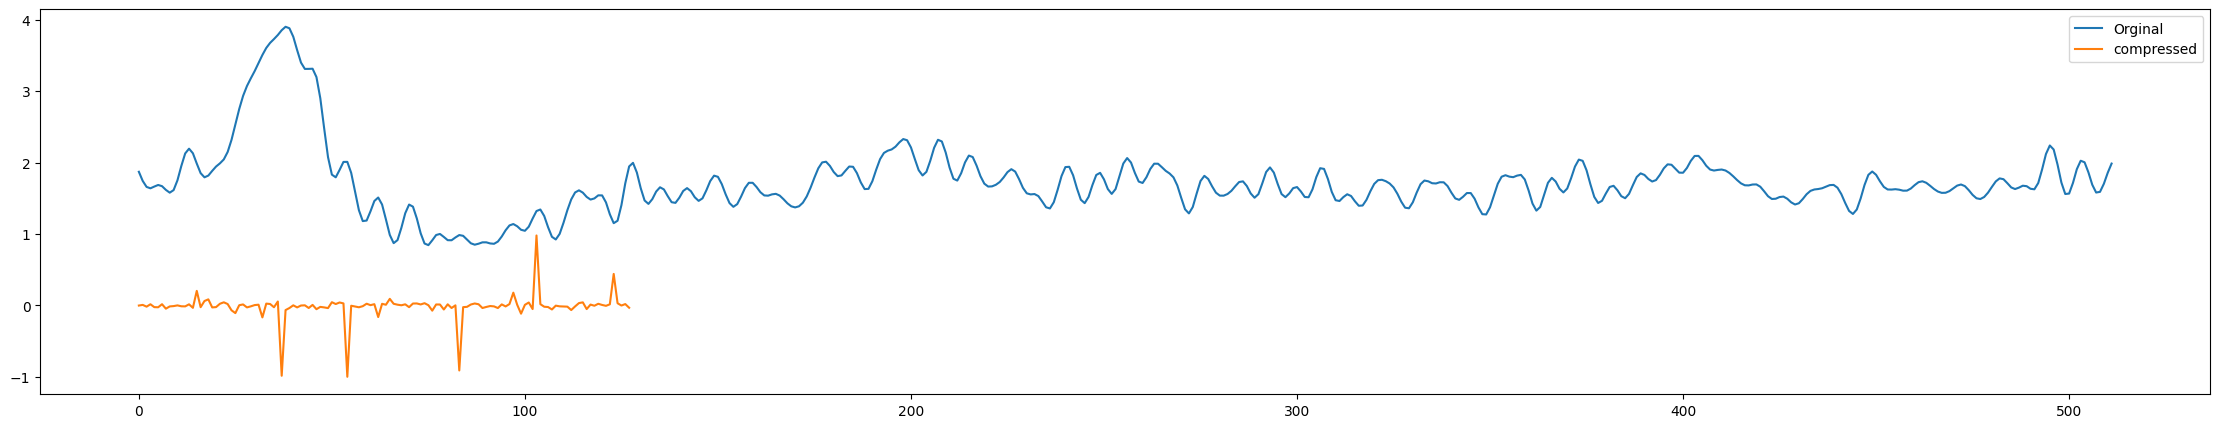

In [ ]:
plt.figure(figsize=(28, 5))
plt.plot(X_test[0], label = 'Orginal')
plt.plot(compressed[0], label = 'compressed')
plt.legend()
plt.show()

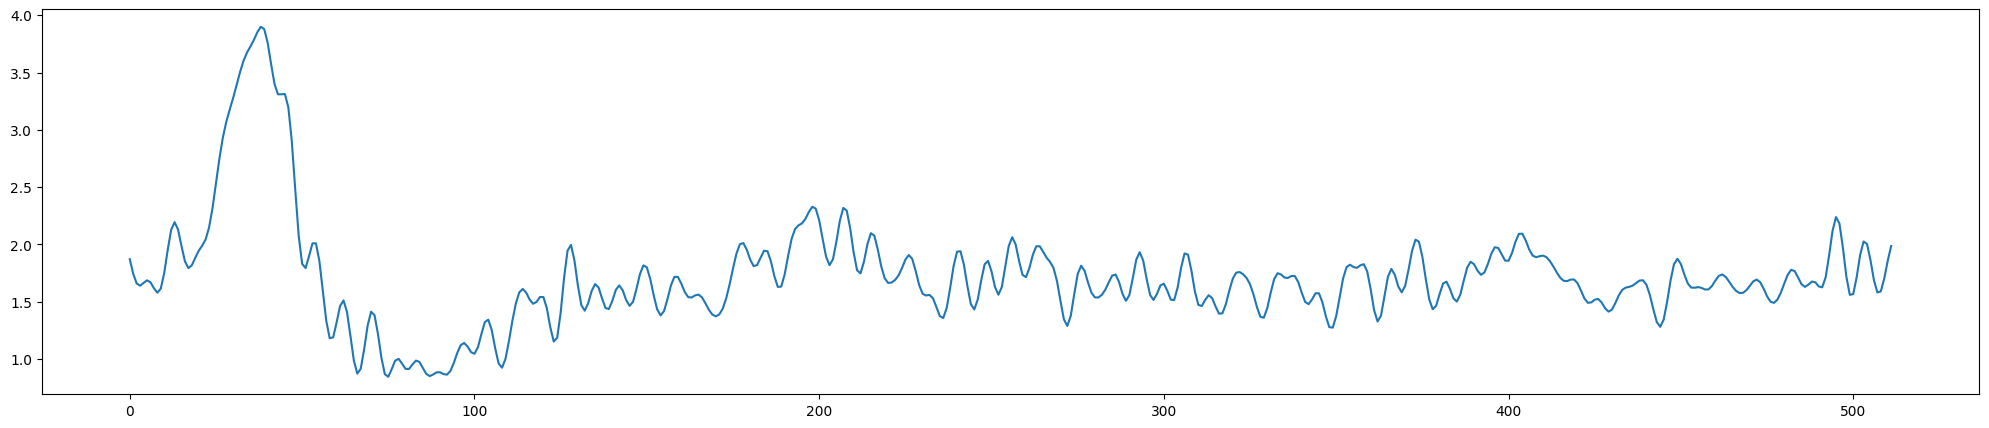

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(X_test[0])

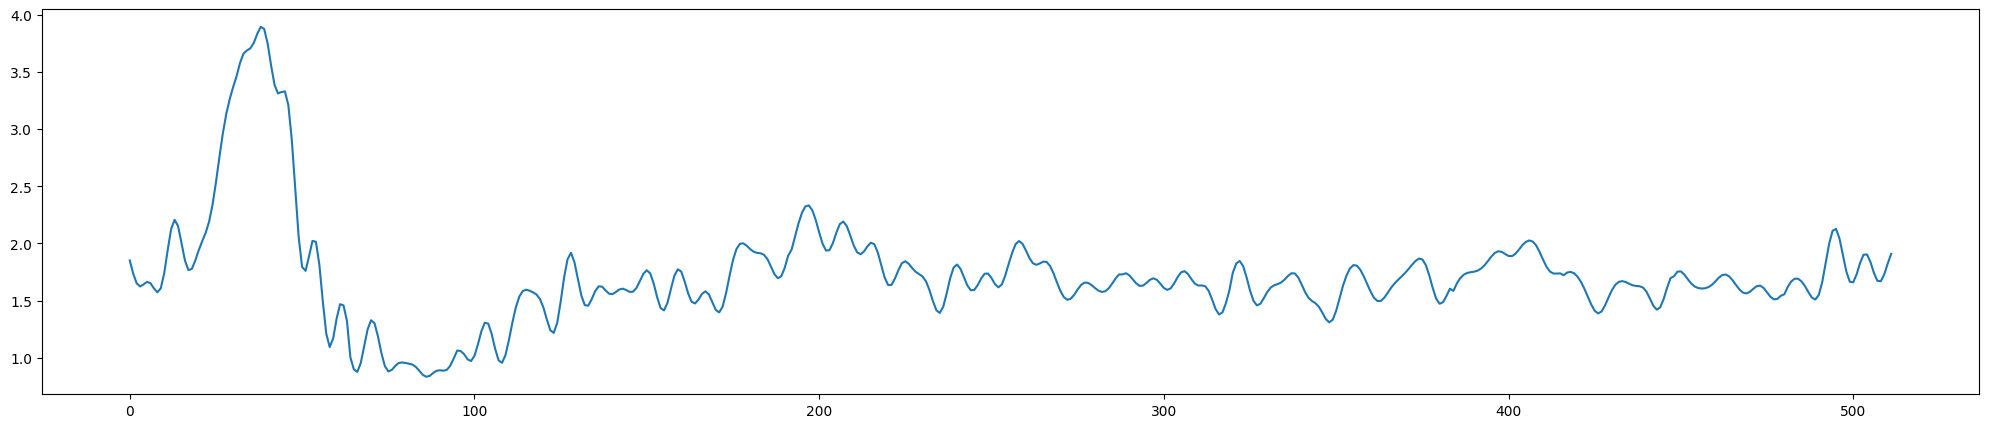

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(y_test[0])

In [ ]:
import pickle

with open('history-GRU(512+32+128).pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:

!cp 'history-GRU(512+32+128).pkl' /content/drive/MyDrive/Training_history/

cp: cannot create regular file '/content/drive/MyDrive/Training_history/': Not a directory


In [ ]:
# prompt: save model as model_256_16_128.keras

autoencoder.save('model_GRU_512_32_128.keras')
!cp 'model_GRU_512_32_128.keras' /content/drive/MyDrive/Training_history/


cp: cannot create regular file '/content/drive/MyDrive/Training_history/': Not a directory


In [ ]:
from skimage.metrics import structural_similarity as ssim

i = 0
X_test = X_train[i:i+100]
y_test = autoencoder(X_test)

X = np.array(X_test).reshape((100, signal_len))
Y = np.array(y_test)

ssim(X, Y, data_range=Y.max() - Y.min())

np.float64(0.9462704015521183)

In [ ]:
X.shape, Y.shape

((100, 512), (100, 512))

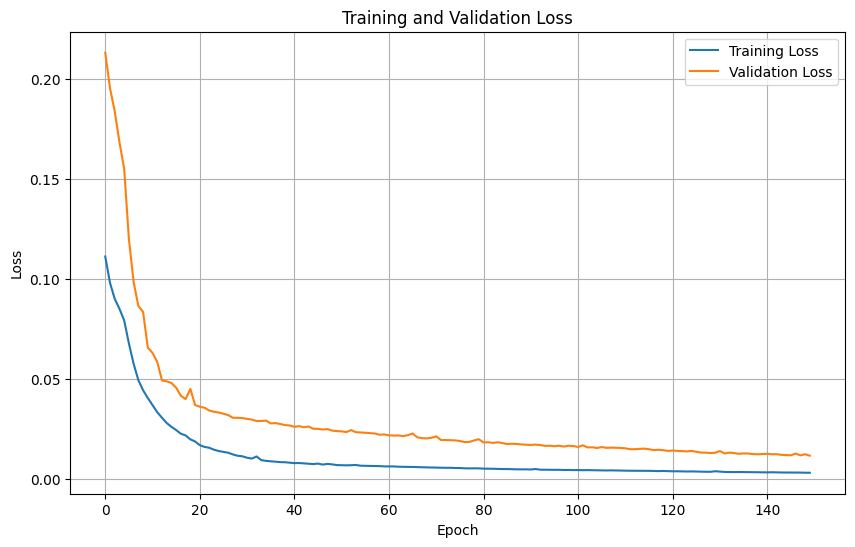

In [ ]:
# prompt: plot loss and val loss from history

import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
